In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sn
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_source_url = "https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"
airline_tweets = pd.read_csv(data_source_url)

In [3]:
airline_tweets.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [4]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

6.0
4.0


In [66]:
airline_tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [67]:
airline_tweets.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

In [68]:
airline_sentiment = airline_tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

In [69]:
sn.barplot(x='airline_sentiment', y='airline_sentiment_confidence' , data=airline_tweets)

In [9]:
features = airline_tweets.iloc[:, 10].values
labels = airline_tweets.iloc[:, 1].values

In [10]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [12]:
from sklearn.metrics import confusion_matrix

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best training params:  {'C': 0.3}
Best training Score:  0.799863387978142
Best training Score:  LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Full results from grid search:  {'mean_fit_time': array([0.14998158, 0.1804076 , 0.25675933]), 'std_fit_time': array([0.01107707, 0.01562141, 0.00621213]), 'mean_score_time': array([0.00405685, 0.00411463, 0.00404906]), 'std_score_time': array([6.38826357e-05, 1.76204073e-05, 1.13088008e-04]), 'param_C': masked_array(data=[0.1, 0.3, 1],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 0.3}, {'C': 1}], 'split0_test_score': array([0.79411012, 0.79692702, 0.79539052]), 'split1_test_score': array([0.7802254

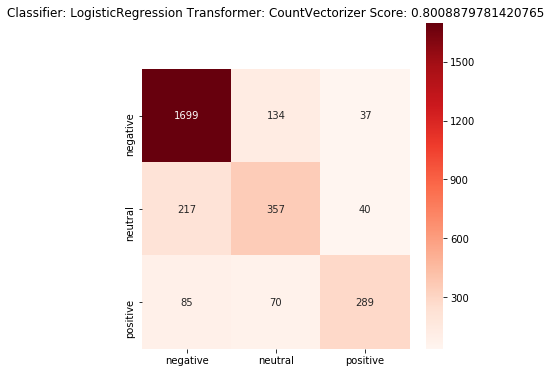

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best training params:  {}
Best training Score:  0.752988387978142
Best training Score:  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Full results from grid search:  {'mean_fit_time': array([0.02472973]), 'std_fit_time': array([0.00092085]), 'mean_score_time': array([0.00365615]), 'std_score_time': array([0.00022364]), 'params': [{}], 'split0_test_score': array([0.75800256]), 'split1_test_score': array([0.74871926]), 'split2_test_score': array([0.75224187]), 'mean_test_score': array([0.75298839]), 'std_test_score': array([0.0038267]), 'rank_test_score': array([1], dtype=int32)}
Best results from grid search:  {}
Classifier: MultinomialNB Transformer: CountVectorizer
F1 score (micro):  0.7739071038251366
F1 score (macro):  0.6624011326360226
Accuracy score:  0.7739071038251366


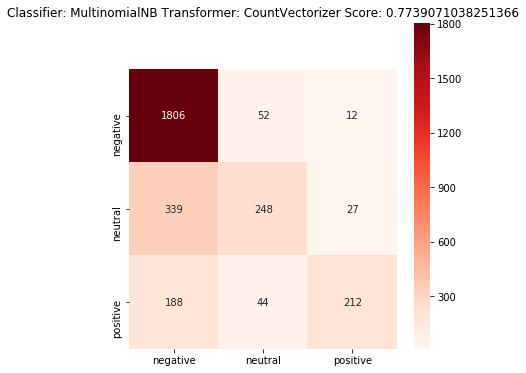

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best training params:  {'max_depth': 20, 'n_estimators': 10}
Best training Score:  0.6421618852459017
Best training Score:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Full results from grid search:  {'mean_fit_time': array([0.02839009, 0.04355375, 0.06385509, 0.0231111 , 0.06492201,
       0.1043179 , 0.02703404, 0.187536  , 0.25377178, 0.04382332,
       0.37399769, 0.52071087]), 'std_fit_time': array([0.00246499, 0.00576266, 0.00692974, 0.00320265, 0.00465797,
       0.01397665, 0.00117869, 0.02277627, 0.00540181, 0.00122362,
       0.01696332, 0.

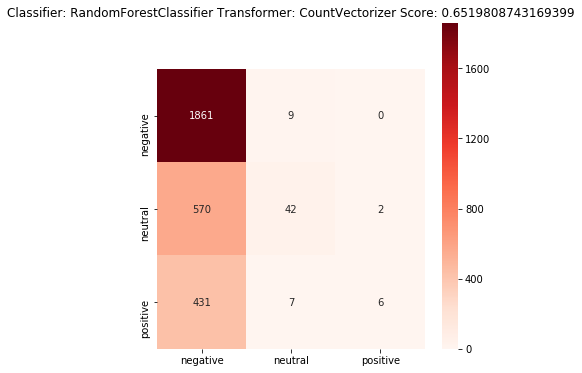

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best training params:  {'C': 1}
Best training Score:  0.7802254098360656
Best training Score:  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Full results from grid search:  {'mean_fit_time': array([0.07487607, 0.11861666, 0.12859829]), 'std_fit_time': array([0.00216895, 0.02479771, 0.0349047 ]), 'mean_score_time': array([0.00481296, 0.00694362, 0.00594727]), 'std_score_time': array([0.00076813, 0.00109573, 0.00170002]), 'param_C': masked_array(data=[0.1, 0.3, 1],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 0.3}, {'C': 1}], 'split0_test_score': array([0.66965429, 0.73725992, 0.78335467]), 'split1_test_score': array([0.67469262, 0.72617828, 

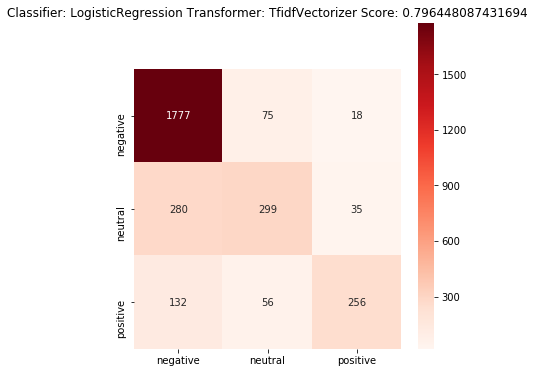

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best training params:  {}
Best training Score:  0.6591530054644809
Best training Score:  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Full results from grid search:  {'mean_fit_time': array([0.03679371]), 'std_fit_time': array([0.0033834]), 'mean_score_time': array([0.00708421]), 'std_score_time': array([0.00131593]), 'params': [{}], 'split0_test_score': array([0.6581306]), 'split1_test_score': array([0.65804303]), 'split2_test_score': array([0.66128619]), 'mean_test_score': array([0.65915301]), 'std_test_score': array([0.00150852]), 'rank_test_score': array([1], dtype=int32)}
Best results from grid search:  {}
Classifier: MultinomialNB Transformer: TfidfVectorizer
F1 score (micro):  0.6813524590163934
F1 score (macro):  0.4131294931710822
Accuracy score:  0.6813524590163934


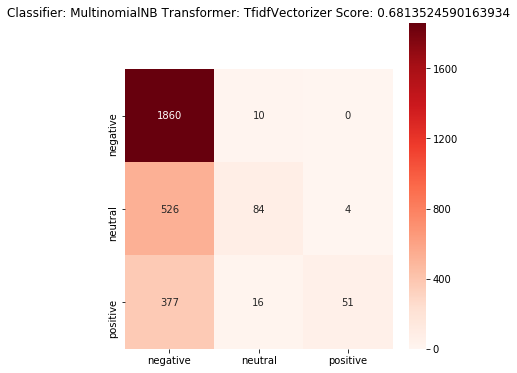

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best training params:  {'max_depth': 20, 'n_estimators': 10}
Best training Score:  0.6496755464480874
Best training Score:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Full results from grid search:  {'mean_fit_time': array([0.02260502, 0.04001077, 0.05105082, 0.01820087, 0.0650293 ,
       0.10198323, 0.02585355, 0.17204674, 0.27423398, 0.06097643,
       0.37969406, 0.56218394]), 'std_fit_time': array([0.00407957, 0.00221202, 0.00247769, 0.0006178 , 0.00339755,
       0.0062446 , 0.0012535 , 0.00926831, 0.0412766 , 0.01170568,
       0.02454629, 0.

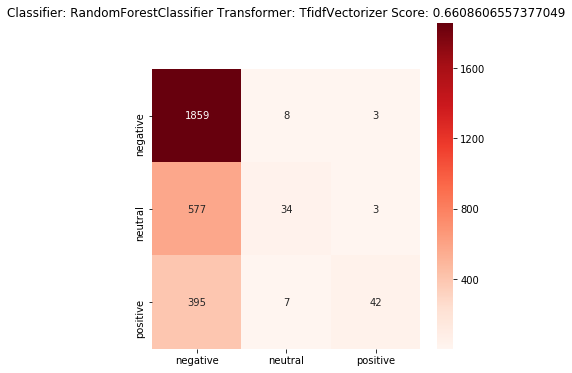

In [13]:
#Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

import itertools

from sklearn.pipeline import make_pipeline
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

transformers = [CountVectorizer(), TfidfVectorizer()]
classifiers = [LogisticRegression(), MultinomialNB(), RandomForestClassifier()]
hyperparameters = {
    "RandomForestClassifier": {"n_estimators": [1, 10, 15], "max_depth": [1,3,10,20]},
    "LogisticRegression": {"C": [0.1, 0.3, 1]},
    "MultinomialNB": {}
}

results = {}

for transformer in transformers:
    transformer.fit(X_train, y_train)
    for classifier in classifiers:
        classifier_name = classifier.__class__.__name__
        gs_classifier = GridSearchCV(classifier, hyperparameters[classifier.__class__.__name__])
        pipeline = make_pipeline(transformer, gs_classifier)
        
        
        pipeline.fit(X_train, y_train)
        
        print(f"Best training params: ", gs_classifier.best_params_)
        print(f"Best training Score: ", gs_classifier.best_score_)
        print(f"Best training Score: ", gs_classifier.best_estimator_)
        
        best_classifier = gs_classifier.best_estimator_
        
        #y_pred      = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        
        test_score = accuracy_score(y_test, y_pred_test)
        
        results[pipeline] = test_score
        
        #plot_confusion_matrix(y_test, y_pred_test, classes = classifier.classes_)
        cm = confusion_matrix(y_test, y_pred_test)
        print(cm)
        index = gs_classifier.classes_
        columns = gs_classifier.classes_
        cm_df = pd.DataFrame(cm,columns,index)                      
        plt.figure(figsize=(6,6))  
        ax = sn.heatmap(cm_df, annot=True, fmt="d", cmap = 'Reds')
        ax.set_ylim(3, -0.5)
        print("Full results from grid search: ", gs_classifier.cv_results_)
        print("Best results from grid search: ", gs_classifier.best_params_)

        print(f"Classifier: {classifier_name} Transformer: {transformer.__class__.__name__}")

        print(f"F1 score (micro): ", f1_score(y_test, y_pred_test, average='micro'))
        print(f"F1 score (macro): ", f1_score(y_test, y_pred_test, average='macro'))
        print(f"Accuracy score: ", accuracy_score(y_test, y_pred_test))
        
        plt.title(f"Classifier: {classifier_name} Transformer: {transformer.__class__.__name__} Score: {test_score}")
        plt.show()
        

In [61]:
class SentimentAnalyzer():
    def __init__(self):
        self.features, self.labels = self.load_data()
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_data()
        self.pipeline = self.train_model()
        
    def load_data(self):
        '''
        Reads in data
        '''
        data_source_url = "https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"
        airline_tweets = pd.read_csv(data_source_url)
        self.features = airline_tweets.iloc[:, 10].values
        self.labels = airline_tweets.iloc[:, 1].values
        return self.features, self.labels
    
    def split_data(self):
        self.processed_features = self.preprocess()
        X_train, X_test, y_train, y_test = train_test_split(processed_features, self.labels, test_size=0.2, random_state=0)
        return X_train, X_test, y_train, y_test  
    
    
    def preprocess(self):
        processed_features = []

        for sentence in range(0, len(self.features)):
            # Remove all the special characters
            processed_feature = re.sub(r'\W', ' ', str(self.features[sentence]))

            # remove all single characters
            processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

            # Remove single characters from the start
            processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

            # Substituting multiple spaces with single space
            processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

            # Removing prefixed 'b'
            processed_feature = re.sub(r'^b\s+', '', processed_feature)

            # Converting to Lowercase
            processed_feature = processed_feature.lower()

            processed_features.append(processed_feature)
            return processed_features

    def train_model(self):
        transformers = [CountVectorizer(), TfidfVectorizer()]
        classifiers = [LogisticRegression(), MultinomialNB(), RandomForestClassifier()]
        hyperparameters = {
    "RandomForestClassifier": {"n_estimators": [1, 10, 15], "max_depth": [1,3,10,20]},
    "LogisticRegression": {"C": [0.1, 0.3, 1]},
    "MultinomialNB": {}
        }

        results = {}

        for transformer in transformers:
            transformer.fit(X_train, y_train)
            for classifier in classifiers:
                classifier_name = classifier.__class__.__name__
                gs_classifier = GridSearchCV(classifier, hyperparameters[classifier.__class__.__name__])
                pipeline = make_pipeline(transformer, gs_classifier)
        
                pipeline.fit(X_train, y_train)
        
                best_classifier = gs_classifier.best_estimator_
                
                return pipeline
    
    def evaluate(self):
        results={}
        print(f"Best training params: ", gs_classifier.best_params_)
        print(f"Best training Score: ", gs_classifier.best_score_)
        print(f"Best training Score: ", gs_classifier.best_estimator_)
      
        y_pred_test = self.pipeline.predict(self.X_test)
      
        test_score = accuracy_score(self.y_test, y_pred_test)
      
        results[self.pipeline] = test_score
        #plot_confusion_matrix(y_test, y_pred_test, classes = classifier.classes_)
        cm = confusion_matrix(self.y_test, y_pred_test)  
        index = gs_classifier.classes_
        columns = gs_classifier.classes_
        cm_df = pd.DataFrame(cm,columns,index)                      
        plt.figure(figsize=(6,6))  
        ax = sn.heatmap(cm_df, annot=True, fmt="d", cmap = 'Reds')
        ax.set_ylim(3, -0.5)
        print("Full results from grid search: ", gs_classifier.cv_results_)
        print("Best results from grid search: ", gs_classifier.best_params_)

        print(f"Classifier: {classifier_name} Transformer: {transformer.__class__.__name__}")

        print(f"F1 score (micro): ", f1_score(self.y_test, y_pred_test, average='micro'))
        print(f"F1 score (macro): ", f1_score(self.y_test, y_pred_test, average='macro'))
        print(f"Accuracy score: ", accuracy_score(self.y_test, y_pred_test))
        
        plt.title(f"Classifier: {classifier_name} Transformer: {transformer.__class__.__name__} Score: {test_score}")
        plt.show()
        

    def classify(self, input):
        sentences = input
        predictions = self.pipeline.predict(sentences)
        print(predictions)


In [65]:
myModel = SentimentAnalyzer()

sentences = ['I like this I feel good about it', 'give me 5 dollars']

myModel.classify(sentences)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


['positive' 'neutral']
